# Main housing construction period

In [1]:
from pynsee.download import get_file_list, get_column_metadata, download_file
from pynsee.geodata import get_geodata, get_geodata_list
from pynsee.geodata import GeoFrDataFrame

import py7zr
import tempfile
import os
import re
import shutil
import math
import urllib.request as request
from contextlib import closing
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
from pandas.api.types import CategoricalDtype
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import descartes

In [2]:
meta = get_file_list()
metacol = get_column_metadata("RP_LOGEMENT_2016")

In [3]:
meta_achl = metacol[metacol["column"] == "ACHL"].reset_index(drop=True)
meta_achl.loc[~meta_achl["value"].isin(["A11", "A12", "B11", "B12", "C100"]), "value"] = ">2005"
meta_achl.loc[meta_achl["value"] == ">2005", "value_label_fr"] = "Après 2005"
meta_achl = meta_achl[["value", "value_label_fr"]].drop_duplicates()
meta_achl.columns = ["ACHL", "ACHL_label_fr"]
meta_achl

,ACHL,ACHL_label_fr
0,A11,Avant 1919
1,A12,De 1919 à 1945
2,B11,De 1946 à 1970
3,B12,De 1971 à 1990
4,C100,De 1991 à 2005
5,>2005,Après 2005


In [5]:
df = download_file("RP_LOGEMENT_2016", variables = ["COMMUNE", "IRIS", "ACHL", "IPONDL"])
DF = df[["COMMUNE", "IRIS", "ACHL", "IPONDL"]].reset_index(drop=True)
DF["IPONDL"] = pd.to_numeric(DF["IPONDL"])
DF = DF.groupby(["COMMUNE", "IRIS", "ACHL"], as_index=False).IPONDL.agg("sum")

Downloading: 100%|██████████| 373M/373M [00:47<00:00, 8.16MiB/s] 
Extracting: 100%|██████████| 4.45G/4.45G [00:15<00:00, 304MB/s]


In [6]:
pondTot = DF.groupby(["COMMUNE", "IRIS"], as_index=False)['IPONDL'].agg('sum')
pondTot = pondTot.rename(columns={'IPONDL': 'pondTot'})
DF = DF.merge(pondTot, on = ["COMMUNE", "IRIS"], how='left')

In [7]:
DF["pct"] = DF["IPONDL"] / DF["pondTot"] * 100
DF.loc[~DF["ACHL"].isin(["A11", "A12", "B11", "B12", "C100"]), "ACHL"] = ">2005"
data = DF.groupby(["COMMUNE", "IRIS", "ACHL"], as_index=False).pct.agg("sum")
data = data.merge(meta_achl, on = "ACHL", how="left")
data.loc[data["IRIS"] == "ZZZZZZZZZ", "IRIS"] = "0000"
data["CODE_IRIS"] = data["IRIS"]
data.loc[data["IRIS"] == "0000", "CODE_IRIS"] = data.loc[data["IRIS"] == "0000", "COMMUNE"] + data.loc[data["IRIS"] == "0000", "IRIS"]

#data.head(10)

In [8]:
data.head(10)

,COMMUNE,IRIS,ACHL,pct,ACHL_label_fr,CODE_IRIS
0,01001,0000,>2005,7.183908,Après 2005,010010000
1,01001,0000,A11,28.735632,Avant 1919,010010000
2,01001,0000,A12,3.160920,De 1919 à 1945,010010000
3,01001,0000,B11,3.448276,De 1946 à 1970,010010000
4,01001,0000,B12,29.310345,De 1971 à 1990,010010000
5,01001,0000,C100,28.160920,De 1991 à 2005,010010000
6,01002,0000,>2005,9.467456,Après 2005,010020000
7,01002,0000,A11,62.130178,Avant 1919,010020000
8,01002,0000,A12,10.059172,De 1919 à 1945,010020000
9,01002,0000,B11,4.733728,De 1946 à 1970,010020000


In [9]:
# https://geoservices.ign.fr/contoursiris
url_ign_iris22 = "https://wxs.ign.fr/1yhlj2ehpqf3q6dt6a2y7b64/telechargement/inspire/CONTOURS-IRIS-PACK_2022-01$CONTOURS-IRIS_2-1__SHP__FRA_2022-01-01/file/CONTOURS-IRIS_2-1__SHP__FRA_2022-01-01.7z"
ign_iris_ftp20 = "https://wxs.ign.fr/1yhlj2ehpqf3q6dt6a2y7b64/telechargement/inspire/CONTOURS-IRIS-2020-01-01$CONTOURS-IRIS_2-1__SHP__FRA_2020-01-01/file/CONTOURS-IRIS_2-1__SHP__FRA_2020-01-01.7z"

def get_iris_data(url=ign_iris_ftp20, update=False):
    
    list_string_split = url.split("/")
    filename = list_string_split[len(list_string_split)-1]
    list_string_split_filename = filename.split(".")
    filename_clean = list_string_split_filename[0]
    
    home = Path.home()
    dataDir = str(home) + "/" + filename_clean
    if not os.path.exists(dataDir):
        os.mkdir(dataDir)

    file_iris = dataDir + "/" + "file_" + filename_clean
        
    if (not os.path.exists(file_iris)) or (update):
        with closing(request.urlopen(url, timeout=None)) as r:
            with open(file_iris, 'wb') as f:
                shutil.copyfileobj(r, f)

    with py7zr.SevenZipFile(file_iris, mode='r') as z:
            z.extractall(dataDir)

    list_file = []
    list_file_size = []

    for root, d_names, f_names in os.walk(dataDir):
        for f in f_names:
            filename = root + "/" + f
            if re.search("CONTOURS-IRIS.shp", filename):
                list_file += [filename]
                list_file_size += [os.path.getsize(filename)]
    
    list_shp_df = []
                
    for f in list_file:  
               
        shp = gpd.read_file(f)
        shp = shp.to_crs("EPSG:3857")
        list_shp_df += [shp]
        
    shpFinal = pd.concat(list_shp_df)
    
    return shpFinal

In [10]:
shapefile = get_iris_data(update=False)

ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


In [11]:
shp = shapefile.sort_values(by = ["INSEE_COM"]).reset_index(drop=True)
shp.loc[shp["IRIS"] == "0000", "IRIS"] = "ZZZZZZZZZ"
shp.rename(columns={'INSEE_COM':'COMMUNE'}, inplace=True)

In [22]:
data['pct_max'] = data.groupby(['COMMUNE', "IRIS"])['pct'].transform('max')
dataMax = data[data["pct"] == data["pct_max"]].reset_index(drop=True)

list_dep_extract = []
for i in dataMax.index:
    dep = dataMax["COMMUNE"].values[i][:3]    
    if not re.search("^97", dep):
        dep = dataMax["COMMUNE"].values[i][:2]          
    list_dep_extract += [dep]
    
dataMax["insee_dep"] = list_dep_extract

dataFinal = dataMax.merge(shp[["CODE_IRIS", "geometry", "NOM_COM"]], on=["CODE_IRIS"], how = "left")

In [23]:
dataFinal["crsCoord"] = "EPSG:3857"
dataFinal = dataFinal.reset_index(drop=True)

In [24]:
# iris limit missing for the following iris 
dataFinal.loc[dataFinal["geometry"].isnull(), ['insee_dep', "COMMUNE", "NOM_COM","CODE_IRIS", "geometry", "pct"]]

,insee_dep,COMMUNE,NOM_COM,CODE_IRIS,geometry,pct
32,01,01033,NaN,010330101,None,36.461395
79,01,01059,NaN,010590000,None,43.548387
109,01,01091,NaN,010910000,None,29.726289
115,01,01097,NaN,010970000,None,44.666667
138,01,01122,NaN,011220000,None,31.134526
...,...,...,...,...,...,...
46557,91,91573,NaN,915730000,None,37.706465
47997,94,94022,NaN,940220101,None,29.998754
47999,94,94022,NaN,940220103,None,28.892205
48000,94,94022,NaN,940220104,None,36.139329


In [25]:
com = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:commune')

In [26]:
list_com = dataFinal.loc[dataFinal["geometry"].isnull()].COMMUNE.unique()

for c in list_com:
    dc = dataFinal[dataFinal["COMMUNE"] == c].reset_index(drop=True)
    if len(dc.index) == 1:
        geo = com[com["insee_com"] == c]
        if len(geo.index) == 1:
            geo = geo.get_geom() 
            dataFinal.loc[(dataFinal["COMMUNE"] == c), "geometry"] = [geo]

In [27]:
dataFinal = dataFinal[~dataFinal.geometry.isnull()]
dataFinal = GeoFrDataFrame(dataFinal).translate()
dataFinal = dataFinal.zoom(["75","92", "93", "91", "77", "78", "95", "94"],
                          factor=1.5, startAngle = math.pi * (1 - 3 * 1/9))

976 is missing from insee_dep column !


In [28]:
dataFinal['ACHL_label_en'] = dataFinal['ACHL_label_fr'].astype(str)
dataFinal = dataFinal.replace({'ACHL_label_en': {"Après": "After", "Avant" : "Before", "De" : "From", "à" : "to"}}, regex=True)
list_ranges_ACHL_label_en = ['Before 1919', 'From 1919 to 1945', 'From 1946 to 1970', 'From 1971 to 1990','From 1991 to 2005', 'After 2005']
dataFinal['ACHL_label_en'] = dataFinal['ACHL_label_en'].astype(CategoricalDtype(categories=list_ranges_ACHL_label_en, ordered=True))


In [29]:
dataFinal.head(3)

,COMMUNE,IRIS,ACHL,pct,ACHL_label_fr,CODE_IRIS,pct_max,insee_dep,geometry,NOM_COM,crsCoord,ACHL_label_en
0,97101,971010101,C100,41.811227,De 1991 à 2005,971010101,41.811227,971,MULTIPOLYGON (((-706086.0658401633 6311115.277...,Les Abymes,EPSG:3857,From 1991 to 2005
1,97101,971010102,B12,42.455305,De 1971 à 1990,971010102,42.455305,971,POLYGON ((-707141.4767627036 6308691.888286703...,Les Abymes,EPSG:3857,From 1971 to 1990
2,97101,971010103,C100,28.151314,De 1991 à 2005,971010103,28.151314,971,POLYGON ((-707141.4767627036 6308691.888286703...,Les Abymes,EPSG:3857,From 1991 to 2005


In [30]:
mapplot = gpd.GeoDataFrame(dataFinal, crs='EPSG:3857')

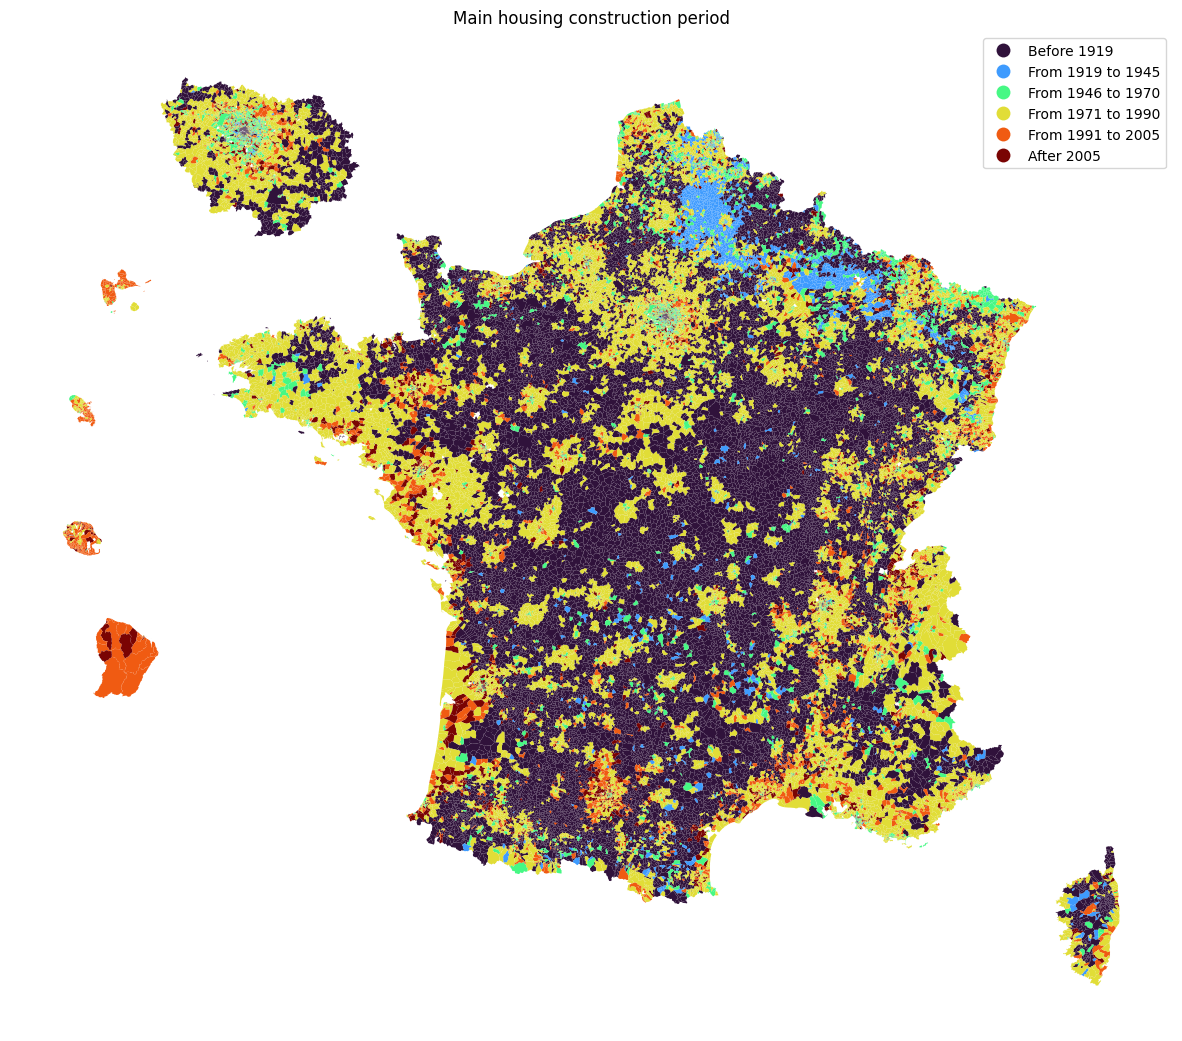

In [31]:
fig, ax = plt.subplots(1,1,figsize=[15,15])
mapplot.plot(column='ACHL_label_en', cmap=cm.turbo,
    legend=True, ax=ax)
ax.set_axis_off()
ax.set(title='Main housing construction period')
plt.show()